## Project Name: Sport Person Classifier
Model Building

### Library Call

In [34]:
import os
import cv2 as cv
import PIL.Image as Image
import numpy as np
import warnings 

warnings.filterwarnings('ignore')

### Celebrity dictionaries

In [19]:
# we will create a dictonary that will contain the celeb-name and their file path
peoples = os.listdir('./Dataset/cropped')

celeb_file_dict = {}

for people in peoples:
    folder_path = os.path.join('./Dataset/cropped', people)
    file_path_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]
    celeb_file_dict[people] = file_path_list

In [20]:
# lets see how many images are there under each sports celebrity
for people, image_list in celeb_file_dict.items():
    print(f'{people}: {len(image_list)} cropped face images')

lionel_messi: 83 cropped face images
maria_sharapova: 50 cropped face images
roger_federer: 68 cropped face images
serena_williams: 61 cropped face images
virat_kohli: 77 cropped face images


In [24]:
# celebrity with encoded name
celeb_encode_dict = {
    'lionel_messi': 0,
    'maria_sharapova': 1,
    'roger_federer': 2,
    'serena_williams': 3,
    'virat_kohli': 4
}

### Resizing and Storing in X and y

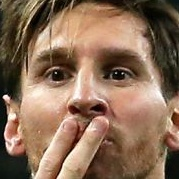

In [21]:
# let's see the first image
Image.open(celeb_file_dict['lionel_messi'][0])

In [22]:
# let's see the shape of the first image
cv.imread(celeb_file_dict['lionel_messi'][0]).shape

(179, 179, 3)

In [25]:
# creating X and y
X, y = [], []

for people, image_list in celeb_file_dict.items():
    for image in image_list:
        img = cv.imread(image)
        resized_img = cv.resize(img, (224, 224))
        X.append(resized_img)
        y.append(celeb_encode_dict[people])

In [31]:
# converting X and y into numpy array
X = np.array(X)
y = np.array(y)

In [33]:
# getting the shape of X data and y
print(f'''
Shape of X: {X.shape}
Shape of y: {y.shape}''')


Shape of X: (339, 224, 224, 3)
Shape of y: (339,)


###  Train-Test-Split
Here we are going to split the dataset into training and testing dataset to see the efficiency with the model. Once we are satisfied with the model we are going to apply the model on the entire dataset.

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [40]:
# scalling 
X_train_scaled = X_train/255
X_test_scaled = X_test/255

### Model Training 

In [37]:
# lets call the pretrained model
from xml.etree.ElementInclude import include
import tensorflow as tf
from tensorflow import keras
vgg = keras.applications.vgg16.VGG16(input_shape = (224, 224, 3),
                                     weights = 'imagenet',
                                     include_top = False)

58889256/58889256 [==============================] - 66s 1us/step


In [38]:
for layer in vgg.layers:
    layer.trainable = False

In [41]:
# building the original model using vgg
model = keras.Sequential([
    vgg,
    keras.layers.Flatten(),
    keras.layers.Dense(5, activation='sigmoid')
])

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [42]:
# fitting the model

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
9/9 [==============================] - 124s 8s/step - loss: 1.8999 - accuracy: 0.3579
Epoch 2/5
9/9 [==============================] - 77s 9s/step - loss: 0.5763 - accuracy: 0.8044
Epoch 3/5
9/9 [==============================] - 86s 10s/step - loss: 0.2360 - accuracy: 0.9299
Epoch 4/5
9/9 [==============================] - 88s 10s/step - loss: 0.1143 - accuracy: 0.9742
Epoch 5/5
9/9 [==============================] - 88s 10s/step - loss: 0.0556 - accuracy: 0.9963


### Model Evaluation

In [43]:
model.evaluate(X_test_scaled, y_test)

3/3 [==============================] - 42s 6s/step - loss: 0.2388 - accuracy: 0.9118


[0.23876813054084778, 0.9117646813392639]

In [47]:
y_pred = [np.argmax(x) for x in model.predict(X_test_scaled)]

3/3 [==============================] - 18s 5s/step


In [48]:
# lets get the classification report 
from sklearn.metrics import classification_report

cf_report = classification_report(y_test, y_pred) 
print(cf_report)

# the results are pretty good!

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       0.88      0.78      0.82         9
           2       1.00      0.83      0.91        18
           3       0.75      1.00      0.86        12
           4       0.92      1.00      0.96        11

    accuracy                           0.91        68
   macro avg       0.91      0.91      0.90        68
weighted avg       0.93      0.91      0.91        68



Text(67.25, 0.5, 'Predicted')

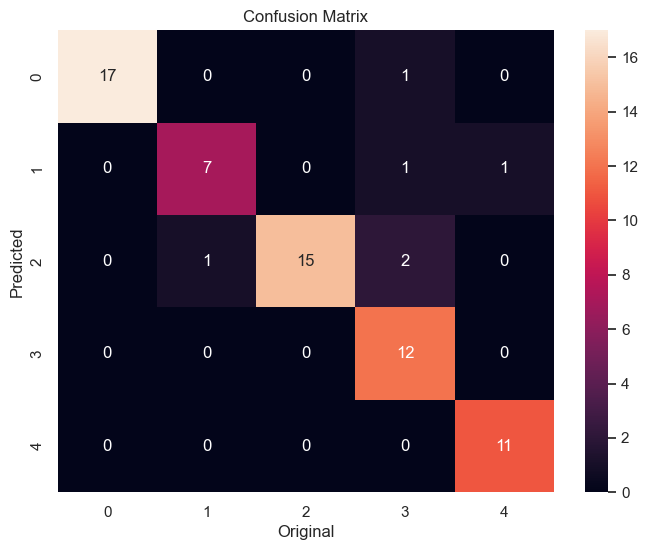

In [50]:
# also lets checkout the confusion matrix
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)

# lets visualise the confusion matrix

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize': (8,6)})
sns.heatmap(conf_mat, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Original')
plt.ylabel('Predicted')

### Final Model Training
As the previously trained model given good result on the training data we are now going to train the model on basis the entire cropped image dataset (without seperating into train and test dataset) that could be used in the app

In [51]:
# scaling X 

X_scaled = X/255

In [56]:
# final model building
final_model = keras.Sequential([
    vgg,
    keras.layers.Flatten(),
    keras.layers.Dense(5, activation='softmax')
])

final_model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

final_model.fit(X_scaled, y, epochs=5)

Epoch 1/5
11/11 [==============================] - 168s 9s/step - loss: 1.7277 - accuracy: 0.3923
Epoch 2/5
11/11 [==============================] - 105s 10s/step - loss: 0.3797 - accuracy: 0.8643
Epoch 3/5
11/11 [==============================] - 113s 10s/step - loss: 0.1511 - accuracy: 0.9558
Epoch 4/5
11/11 [==============================] - 115s 10s/step - loss: 0.0614 - accuracy: 0.9971
Epoch 5/5
11/11 [==============================] - 115s 10s/step - loss: 0.0378 - accuracy: 0.9971


### Saving important artifiacts

In [57]:
final_model.save('./artifacts/model.h5')